In [27]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def generate_sample(alpha, beta, n_samples, sigma_2=1):
    m = lambda x: np.sin(1 / (x / 3 + 0.1))

    X = np.random.beta(a=alpha, b=beta, size=n_samples)
    epsilon = np.random.normal(loc=0, scale=np.sqrt(sigma_2), size=n_samples)
    Y = m(X) + epsilon

    response = Y
    covariate = X
    return covariate, response


In [3]:
x, y = generate_sample(0.1, 0.1, 10000, 0.1)

In [ ]:
def estimate_parameters(covariate, response, bandwith, p=1):
    X = covariate
    Y = response
    h = bandwith
    quartic_kernel = lambda x: (np.abs(x) <= 1) * (15 / 16) * (1 - x**2)**2
    
    def beta_est(x_array):
        n = len(x_array)
        n_params = p + 1
        beta_x = np.empty((n, n_params))
        reg = 1e-5
        
        # Precompute powers of X if p > 0
        #X_powers = np.column_stack([X**p_ for p_ in range(p + 1)])
        
        for idx, x in enumerate(x_array):
            # Vectorized weight computation
            weights = quartic_kernel((X - x) / h)
            sqrt_W = np.sqrt(weights)
            
            # Weighted design matrix: sqrt(W) * X_matrix
            X_diff_powers = np.column_stack([(X - x)**p_ for p_ in range(p + 1)])
            X_weighted = sqrt_W[:, None] * X_diff_powers
            Y_weighted = sqrt_W * Y
            
            # Solve via Cholesky (faster than full inverse)
            XtWX = X_weighted.T @ X_weighted
            XtWX[np.diag_indices_from(XtWX)] += reg
            
            beta_x[idx] = np.linalg.solve(XtWX, X_weighted.T @ Y_weighted)
        
        return beta_x
   
    return beta_est


def est_h_IMSE(sigma_2_hat, theta_22, size):
    # Note that support is [0, 1] (beta distribution)
    h_IMSE = size**(-1/5) * ((35 * sigma_2_hat * 1) / theta_22)**(1/5)
    
    return h_IMSE

In [9]:
""" def estimate_sigma_theta_worked_v2(covariate, response, bandwith = 0.1, N_blocks = 10):
    # Build the blocks
    size = len(covariate)
    block_size = size // N_blocks
    sorted_indices = np.argsort(covariate)  
    X_sorted = covariate[sorted_indices]     
    Y_sorted = response[sorted_indices] 
    covariate_blocks = []
    response_blocks = []
    for i in range(N_blocks):
        start = i * block_size
        end = (i + 1) * block_size if i < N_blocks - 1 else size
        
        covariate_blocks.append(X_sorted[start:end])
        response_blocks.append(Y_sorted[start:end])

    # Estimate for each block:
    m_j_list = []
    for j in range(len(covariate_blocks)):
        beta_est = estimate_parameters(covariate_blocks[j], response_blocks[j], bandwith, p = 4)
        m_j_evaluated_at_xi = beta_est(covariate)
        m_j_list.append(m_j_evaluated_at_xi)    #index j corresponds to the j-th block, then access array of evaluations

    sigma_2_hat, theta_22 = 0, 0

    for j in range(len(covariate_blocks)):
        X_block = covariate_blocks[j]
        Y_block = response_blocks[j]
        for idx, xi in enumerate(X_block):
            yi = Y_block[idx]
            
            # index of xi in the sorted covariate array
            k = np.where(X_sorted == xi)[0][0]
            beta_row = m_j_list[j][k]   # coefficients for xi under block j
            
            m_val = beta_row[0]
            m_dd_val = 2 * beta_row[2]
            
            theta_22 += m_val * m_dd_val
            sigma_2_hat += (yi - m_val)**2

    theta_22 /= size
    sigma_2_hat /= (size - 5 * N_blocks)


    theta_22 /= size
    sigma_2_hat /= (size - 5 * N_blocks)

    return sigma_2_hat, theta_22 """

def estimate_sigma_theta_worked_v3(covariate, response, bandwith=0.1, N_blocks=10):
    # Build the blocks
    size = len(covariate)
    block_size = size // N_blocks
    sorted_indices = np.argsort(covariate)  
    X_sorted = covariate[sorted_indices]    
    Y_sorted = response[sorted_indices]
    
    covariate_blocks = []
    response_blocks = []
    for i in range(N_blocks):
        start = i * block_size
        end = (i + 1) * block_size if i < N_blocks - 1 else size
        covariate_blocks.append(X_sorted[start:end])
        response_blocks.append(Y_sorted[start:end])
    
    # Estimate for each block
    m_j_list = []
    for j in range(len(covariate_blocks)):
        beta_est = estimate_parameters(covariate_blocks[j], response_blocks[j], bandwith, p=4)
        m_j_evaluated_at_xi = beta_est(covariate)
        m_j_list.append(m_j_evaluated_at_xi)
    
    sigma_2_hat, theta_22 = 0, 0
    
    for j in range(len(covariate_blocks)):
        X_block = covariate_blocks[j]
        Y_block = response_blocks[j]
        
        for idx, xi in enumerate(X_block):
            yi = Y_block[idx]
            
            # Use the original index mapping instead of searching
            original_idx = j * block_size + idx
            if original_idx >= len(covariate):
                original_idx = len(covariate) - 1
            
            beta_row = m_j_list[j][original_idx]
            
            m_val = beta_row[0]
            m_dd_val = 2 * beta_row[2]  # second derivative
            
            # Standard formula: theta_22 is integrated (m'')^2
            theta_22 += m_dd_val**2
            sigma_2_hat += (yi - m_val)**2
    
    # Normalize (only once!)
    theta_22 /= size
    sigma_2_hat /= (size - 5 * N_blocks)
    
    return sigma_2_hat, theta_22

# Tests

In [15]:
sigma_2_hat, theta_22 = estimate_sigma_theta_worked_v3(covariate=x, response=y, bandwith=0.1, N_blocks=10)

In [16]:
print("sigma_2_hat: ", sigma_2_hat, " | theta_22: ", theta_22)
h_IMSE = est_h_IMSE(sigma_2_hat, theta_22, size=10000)

print("h_IMSE: ", h_IMSE)

sigma_2_hat:  0.5681203704549628  | theta_22:  4741.553146382011
h_IMSE:  0.05302950297070202


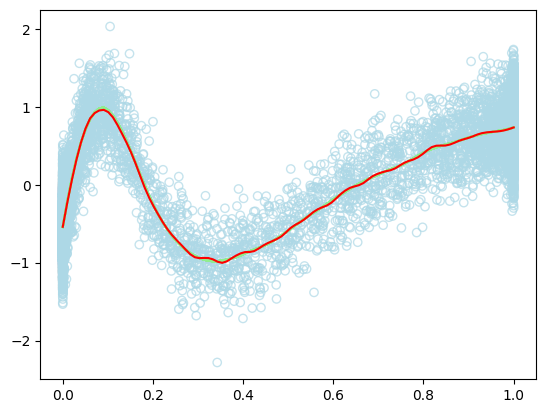

In [25]:
#beta_fct_default = estimate_parameters(x, y, 0.1, p=2)
beta_fct_opti = estimate_parameters(x, y, h_IMSE, p=2)

p = np.linspace(0, 1, 100)
#beta_values_default = beta_fct_default(p) 
beta_values_opti = beta_fct_opti(p)

plt.scatter(x, y, marker='o', facecolors='none', edgecolors='lightblue', alpha=0.7)

for h in np.arange(0.01, 0.99, step=0.08):
    beta_fct_default = estimate_parameters(x, y, 0.1, p=2)
    beta_values_default = beta_fct_default(p) 
    plt.plot(p, beta_values_default[:, 0], color="lightgreen", label=r"fit$")

plt.plot(p, beta_values_opti[:, 0], color="red", label=r"fit w/ optimized $h_{{IMSE}}$")


# Simulation function

In [33]:
def simulate(alpha, beta, number_of_samples, error_variance, default_bandwith, number_of_blocks):
    covariate, response = generate_sample(alpha=alpha,
                                          beta=beta,
                                          n_samples = number_of_samples,
                                          sigma_2=error_variance)
    
    sigma_2_est, theta_22_est = estimate_sigma_theta_worked_v3(covariate=covariate,
                                                               response=response,
                                                               bandwith=default_bandwith,
                                                               N_blocks=number_of_blocks)
    
    h_IMSE_est = est_h_IMSE(sigma_2_est, theta_22_est, size=number_of_samples)

    return h_IMSE_est, sigma_2_est, theta_22_est

# Simulation Study

### Impact of alpha, beta

Iteration 1 / 400 | Computed results for (alpha, beta)=(0.01, 0.01)
Iteration 2 / 400 | Computed results for (alpha, beta)=(0.01, 0.51)
Iteration 3 / 400 | Computed results for (alpha, beta)=(0.01, 1.01)
Iteration 4 / 400 | Computed results for (alpha, beta)=(0.01, 1.51)
Iteration 5 / 400 | Computed results for (alpha, beta)=(0.01, 2.01)
Iteration 6 / 400 | Computed results for (alpha, beta)=(0.01, 2.51)
Iteration 7 / 400 | Computed results for (alpha, beta)=(0.01, 3.01)
Iteration 8 / 400 | Computed results for (alpha, beta)=(0.01, 3.51)
Iteration 9 / 400 | Computed results for (alpha, beta)=(0.01, 4.01)
Iteration 10 / 400 | Computed results for (alpha, beta)=(0.01, 4.51)
Iteration 11 / 400 | Computed results for (alpha, beta)=(0.01, 5.01)
Iteration 12 / 400 | Computed results for (alpha, beta)=(0.01, 5.51)
Iteration 13 / 400 | Computed results for (alpha, beta)=(0.01, 6.01)
Iteration 14 / 400 | Computed results for (alpha, beta)=(0.01, 6.51)
Iteration 15 / 400 | Computed results for (

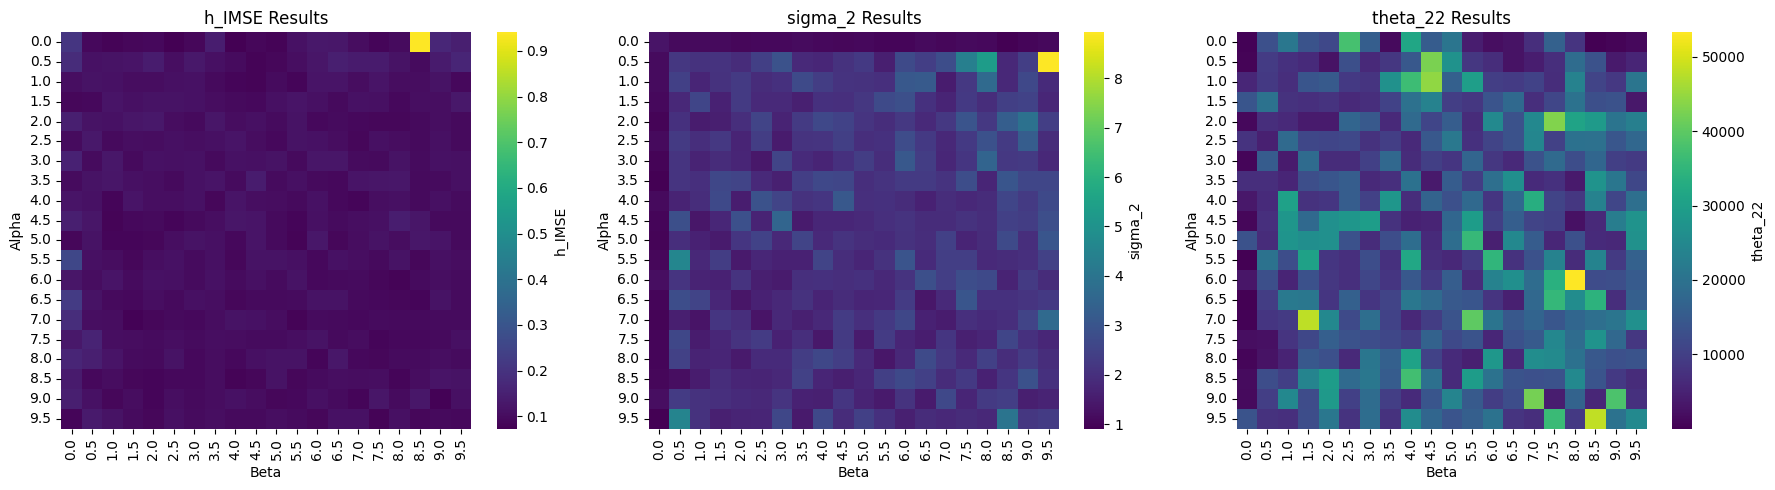

In [ ]:
alphas = np.arange(0.01, 10, step = 0.5)
betas = np.arange(0.01, 10, step = 0.5)

number_of_samples = 500
error_variance = 1
default_bandwith = 0.1
number_of_blocks = 5




res_h_IMSE = np.zeros((len(alphas), len(betas)))
res_sigma_2 = np.zeros((len(alphas), len(betas)))
res_theta_22 = np.zeros((len(alphas), len(betas)))

total_iterations = len(alphas) * len(betas)
current_iteration = 0
for (a_idx, a) in enumerate(alphas):
    for (b_idx, b) in enumerate(betas):
        current_iteration += 1
        res_h_IMSE[a_idx, b_idx], res_sigma_2[a_idx, b_idx], res_theta_22[a_idx, b_idx] =\
            simulate(alpha = a,
                    beta=b,
                    error_variance=error_variance,
                    number_of_samples=number_of_samples,
                    default_bandwith=default_bandwith,
                    number_of_blocks=number_of_blocks)
        print(f"Iteration {current_iteration} / {total_iterations} | Computed results for (alpha, beta)=({a}, {b})")
        


""" fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heatmap 1: h_IMSE
sns.heatmap(res_h_IMSE, ax=axes[0], cmap='viridis', 
            xticklabels=np.round(betas, 1), yticklabels=np.round(alphas, 1),
            cbar_kws={'label': 'h_IMSE'})
axes[0].set_xlabel('Beta')
axes[0].set_ylabel('Alpha')
axes[0].set_title('h_IMSE Results')

# Heatmap 2: sigma_2
sns.heatmap(res_sigma_2, ax=axes[1], cmap='viridis',
            xticklabels=np.round(betas, 1), yticklabels=np.round(alphas, 1),
            cbar_kws={'label': 'sigma_2'})
axes[1].set_xlabel('Beta')
axes[1].set_ylabel('Alpha')
axes[1].set_title('sigma_2 Results')

# Heatmap 3: theta_22
sns.heatmap(res_theta_22, ax=axes[2], cmap='viridis',
            xticklabels=np.round(betas, 1), yticklabels=np.round(alphas, 1),
            cbar_kws={'label': 'theta_22'})
axes[2].set_xlabel('Beta')
axes[2].set_ylabel('Alpha')
axes[2].set_title('theta_22 Results')

plt.tight_layout()
plt.show() """

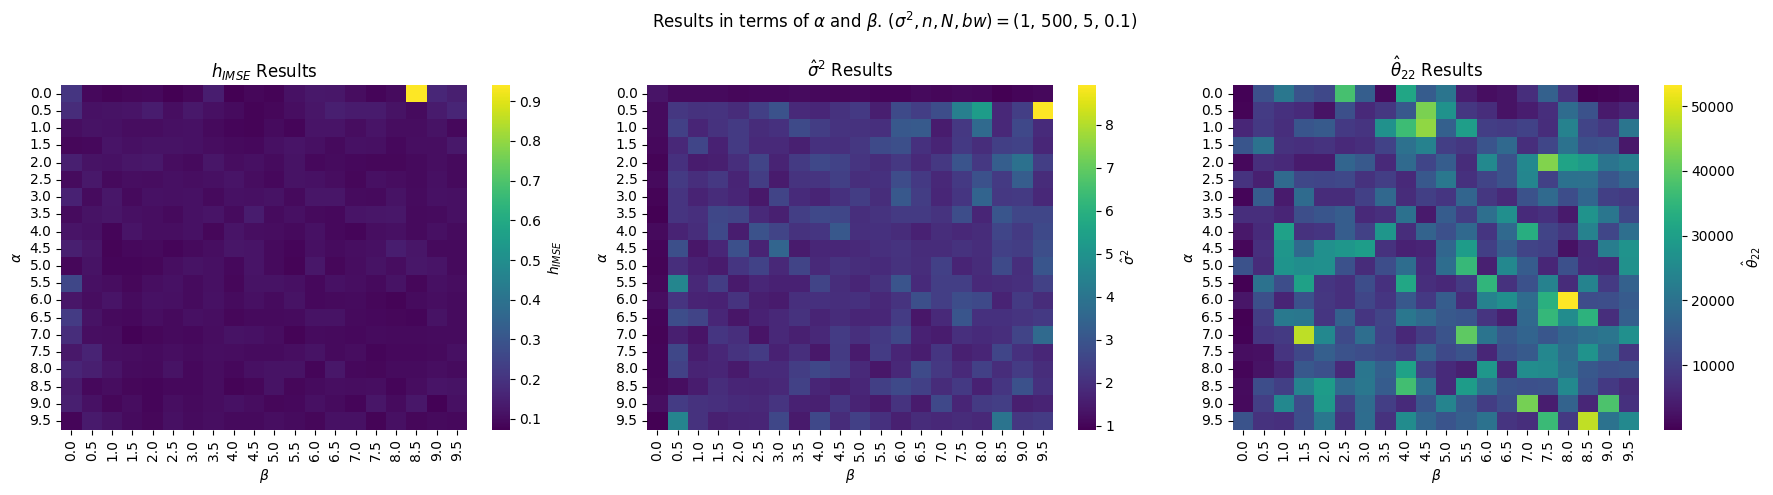

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heatmap 1: h_IMSE
sns.heatmap(res_h_IMSE, ax=axes[0], cmap='viridis', 
            xticklabels=np.round(betas, 1), yticklabels=np.round(alphas, 1),
            cbar_kws={'label': r"$h_{IMSE}$"})
axes[0].set_xlabel(r"$\beta$")
axes[0].set_ylabel(r"$\alpha$")
axes[0].set_title(r'$h_{IMSE}$ Results')

# Heatmap 2: sigma_2
sns.heatmap(res_sigma_2, ax=axes[1], cmap='viridis',
            xticklabels=np.round(betas, 1), yticklabels=np.round(alphas, 1),
            cbar_kws={'label': r"$\hat\sigma^2$"})
axes[1].set_xlabel(r"$\beta$")
axes[1].set_ylabel(r"$\alpha$")
axes[1].set_title(r"$\hat\sigma^{2}$ Results")

# Heatmap 3: theta_22
sns.heatmap(res_theta_22, ax=axes[2], cmap='viridis',
            xticklabels=np.round(betas, 1), yticklabels=np.round(alphas, 1),
            cbar_kws={'label': r"$\hat\theta_{22}$"})
axes[2].set_xlabel(r"$\beta$")
axes[2].set_ylabel(r"$\alpha$")
axes[2].set_title(r"$\hat\theta_{22}$ Results")

plt.suptitle(rf"Results in terms of $\alpha$ and $\beta$. $(\sigma^2, n, N, bw)=$({error_variance}, {number_of_samples}, {number_of_blocks}, {default_bandwith})")
plt.tight_layout()
plt.show()

### Variation of the estimation wrt. sample size and number of blocks

In [51]:
number_of_samples_range = np.arange(start=100, stop=5000 + 1, step = 50)
block_sizes_range = np.arange(start = 2, stop = 10 + 1, step = 2)

alpha = 0.1
beta = 0.1
error_variance = 1
default_bandwith = 0.1


res_h_IMSE = np.zeros((len(number_of_samples_range), len(block_sizes_range)))
res_sigma_2 = np.zeros((len(number_of_samples_range), len(block_sizes_range)))
res_theta_22 = np.zeros((len(number_of_samples_range), len(block_sizes_range)))

total_iterations = len(number_of_samples_range) * len(block_sizes_range)
current_iteration = 0
for (smp_idx, n_smp) in enumerate(number_of_samples_range):
    for (blo_idx, n_blo) in enumerate(block_sizes_range):
        current_iteration += 1
        res_h_IMSE[smp_idx, blo_idx], res_sigma_2[smp_idx, blo_idx], res_theta_22[smp_idx, blo_idx] =\
            simulate(alpha=alpha,
                    beta=beta,
                    error_variance=error_variance,
                    number_of_samples=n_smp,
                    default_bandwith=default_bandwith,
                    number_of_blocks=n_blo)
        print(f"Iteration {current_iteration} / {total_iterations} | Computed results for (n_smp, n_blo)=({n_smp}, {n_blo})")

Iteration 1 / 495 | Computed results for (n_smp, n_blo)=(100, 2)
Iteration 2 / 495 | Computed results for (n_smp, n_blo)=(100, 4)
Iteration 3 / 495 | Computed results for (n_smp, n_blo)=(100, 6)
Iteration 4 / 495 | Computed results for (n_smp, n_blo)=(100, 8)
Iteration 5 / 495 | Computed results for (n_smp, n_blo)=(100, 10)
Iteration 6 / 495 | Computed results for (n_smp, n_blo)=(150, 2)
Iteration 7 / 495 | Computed results for (n_smp, n_blo)=(150, 4)
Iteration 8 / 495 | Computed results for (n_smp, n_blo)=(150, 6)
Iteration 9 / 495 | Computed results for (n_smp, n_blo)=(150, 8)
Iteration 10 / 495 | Computed results for (n_smp, n_blo)=(150, 10)
Iteration 11 / 495 | Computed results for (n_smp, n_blo)=(200, 2)
Iteration 12 / 495 | Computed results for (n_smp, n_blo)=(200, 4)
Iteration 13 / 495 | Computed results for (n_smp, n_blo)=(200, 6)
Iteration 14 / 495 | Computed results for (n_smp, n_blo)=(200, 8)
Iteration 15 / 495 | Computed results for (n_smp, n_blo)=(200, 10)
Iteration 16 / 4

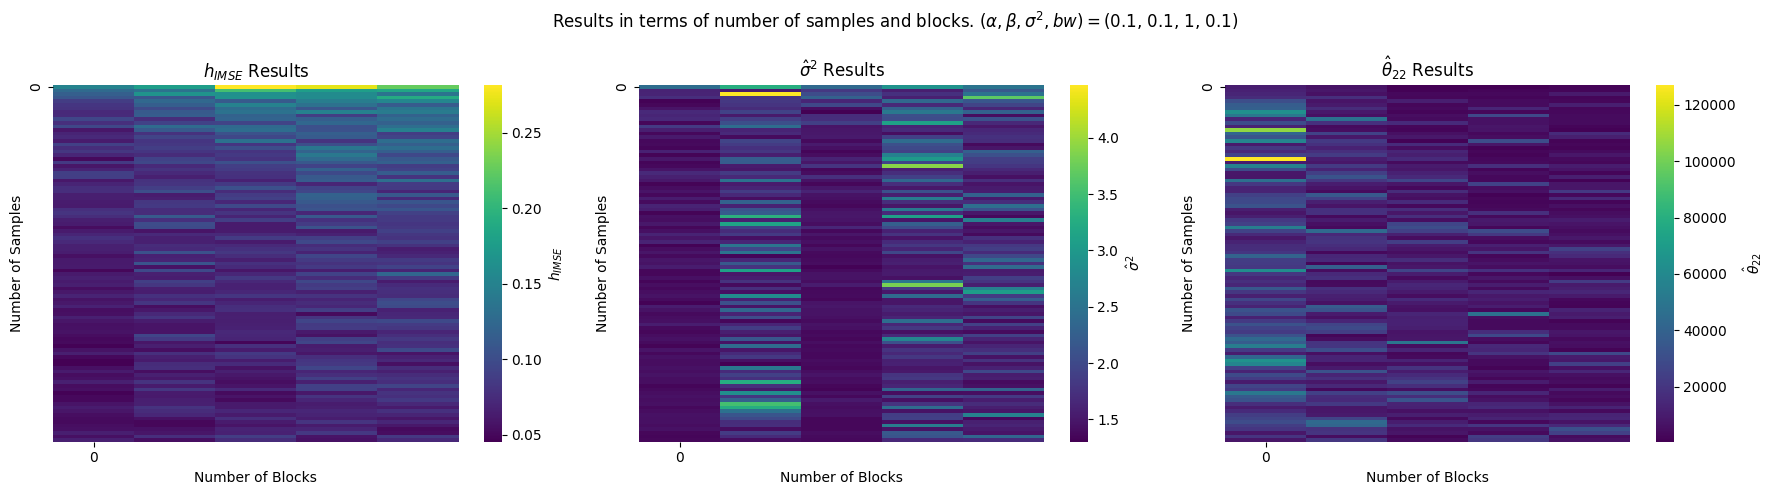

In [53]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Heatmap 1: h_IMSE
sns.heatmap(res_h_IMSE, ax=axes[0], cmap='viridis',
            xticklabels=number_of_blocks, yticklabels=number_of_samples,
            cbar_kws={'label': r"$h_{IMSE}$"})
axes[0].set_xlabel('Number of Blocks')
axes[0].set_ylabel('Number of Samples')
axes[0].set_title(r'$h_{IMSE}$ Results')

# Heatmap 2: sigma_2
sns.heatmap(res_sigma_2, ax=axes[1], cmap='viridis',
            xticklabels=number_of_blocks, yticklabels=number_of_samples,
            cbar_kws={'label': r"$\hat\sigma^2$"})
axes[1].set_xlabel('Number of Blocks')
axes[1].set_ylabel('Number of Samples')
axes[1].set_title(r"$\hat\sigma^{2}$ Results")

# Heatmap 3: theta_22
sns.heatmap(res_theta_22, ax=axes[2], cmap='viridis',
            xticklabels=number_of_blocks, yticklabels=number_of_samples,
            cbar_kws={'label': r"$\hat\theta_{22}$"})
axes[2].set_xlabel('Number of Blocks')
axes[2].set_ylabel('Number of Samples')
axes[2].set_title(r"$\hat\theta_{22}$ Results")

plt.suptitle(rf"Results in terms of number of samples and blocks. $(\alpha, \beta, \sigma^2, bw)=$({alpha}, {beta}, {error_variance}, {default_bandwith})")
plt.tight_layout()
plt.show()

In [ ]:
print(res_h_IMSE)

### Compute error compared to MC estimation